In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.svm import SVC
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
from nltk.tokenize import word_tokenize
import re
import warnings 

stop=set(stopwords.words('english'))
warnings.filterwarnings("ignore")
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


In [7]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [6]:
print('Train Data size :{}'.format(train_df.shape))
print('Test Data size :{}'.format(test_df.shape))

Train Data size :(7613, 5)
Test Data size :(3263, 4)


In [8]:
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
train_df.groupby('location')['id'].count()

location
                          1
  Glasgow                 1
  Melbourne, Australia    1
  News                    1
  å_                      1
                         ..
å_: ?? ÌÑ ? : ?           1
å_å_Los Mina Cityã¢      1
å¡å¡Midwest Û¢Û¢        1
åÊ(?Û¢`?Û¢å«)??         1
åø\_(?)_/åø               1
Name: id, Length: 3341, dtype: int64

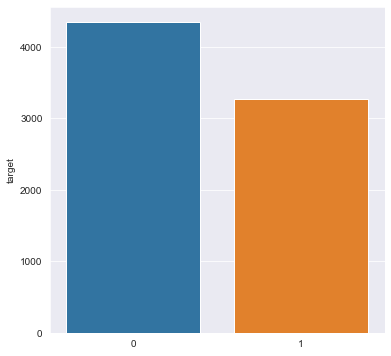

In [10]:
sns.set_style('darkgrid')
plt.figure(figsize=(6,6))
x=train_df['target'].value_counts()
sns.barplot(x.index,x)

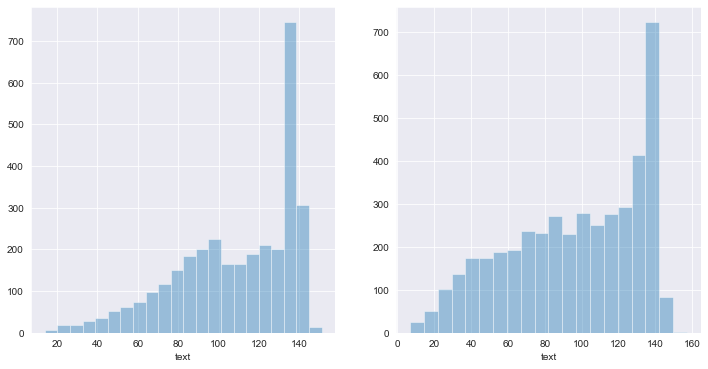

In [11]:
fig,axes = plt.subplots(1,2,figsize=(12,6))
char_len = train_df[train_df['target']==1]['text'].str.len()
sns.distplot(char_len,ax=axes[0],kde=False)

char_len = train_df[train_df['target']==0]['text'].str.len()
sns.distplot(char_len,ax=axes[1],kde=False)

In [12]:

temp = pd.DataFrame(train_df[train_df['target']==0].groupby('keyword')['id'].count())
temp.sort_values('id',ascending=False,inplace=True)
sns.barplot(temp.index[:10],temp['id'][:10],ax=axes[0]).set_title('Normal Tweets')


temp = pd.DataFrame(train_df[train_df['target']==1].groupby('keyword')['id'].count())
temp.sort_values('id',ascending=False,inplace=True)
sns.barplot(temp.index[:10],temp['id'][:10],ax=axes[1]).set_title('Disaster Tweets')

Text(0.5, 1.0, 'Disaster Tweets')

In [14]:
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

HT_regular = hashtag_extract(train_df['text'][train_df['target'] == 0])

# extracting hashtags from racist/sexist tweets
HT_disaster = hashtag_extract(train_df['text'][train_df['target'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_disaster = sum(HT_disaster,[])

Text(0.5, 1.0, 'Disaster Tweets')

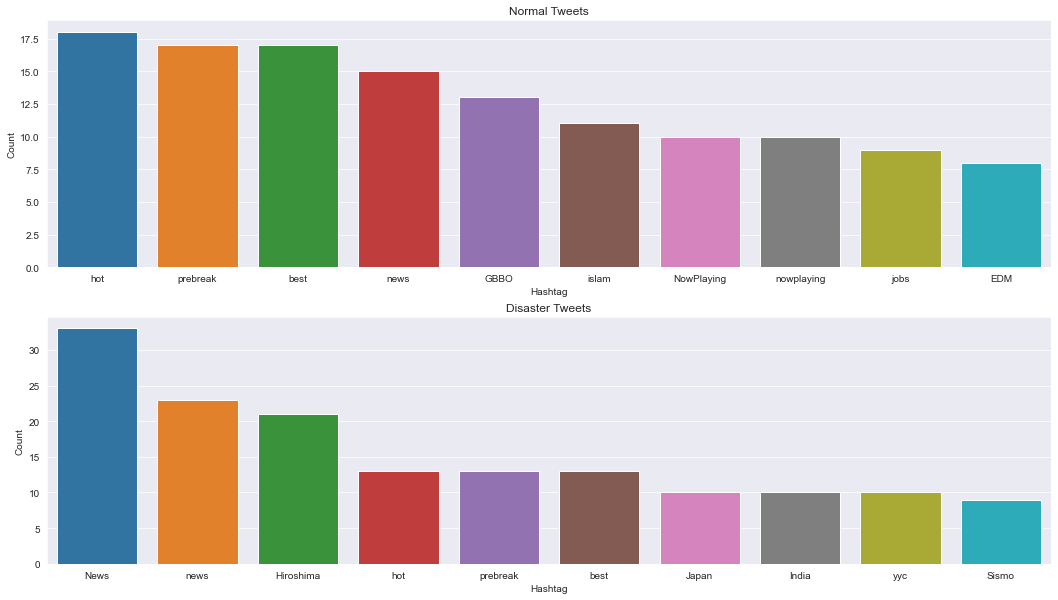

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

In [15]:
fig,axes = plt.subplots(2,1,figsize=(18,10))

a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
sns.barplot(data=d, x= "Hashtag", y = "Count",ax=axes[0]).set_title('Normal Tweets')


a = nltk.FreqDist(HT_disaster)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
sns.barplot(data=d, x= "Hashtag", y = "Count",ax=axes[1]).set_title('Disaster Tweets')

In [16]:
Merge_df = train_df.append(test_df,ignore_index=True)

In [17]:
def remove_pattern(input_txt, pattern):
    reg_obj = re.compile(pattern)
    input_txt = reg_obj.sub(r'', input_txt)
        
    return input_txt 

In [18]:
Merge_df['text'] = Merge_df['text'].apply(lambda x: remove_pattern(x,"@[\w]*"))

In [19]:
# Reference : https://www.kaggle.com/shahules/tweets-complete-eda-and-basic-modeling

Merge_df['text'] = Merge_df['text'].apply(lambda x: remove_pattern(x,'https?://\S+|www\.\S+'))
Merge_df['text'] = Merge_df['text'].apply(lambda x: remove_pattern(x,'<.*?>'))

In [20]:
Merge_df['text'] = Merge_df['text'].apply(lambda x: remove_pattern(x,"[^a-zA-Z# ]"))

In [21]:
def remove_stop_words(text):
    
    word_tokens = word_tokenize(text) 
  
    filtered_sentence = [w for w in word_tokens if not w in stop] 
    
    filtered_tweet = ' '.join(filtered_sentence)
    
    return filtered_tweet

In [22]:
Merge_df['text'] = Merge_df['text'].apply(lambda x: remove_stop_words(x))

In [23]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def tokenize_stem(text):
    
    token_words = word_tokenize(text)
    stem_words =[]
    for i in token_words:
        word = lemmatizer.lemmatize(i)
        stem_words.append(word)
        
    final_tweet = ' '.join(stem_words)
    
    return final_tweet

In [26]:
Merge_df['text'] = Merge_df['text'].apply(lambda x: tokenize_stem(x))

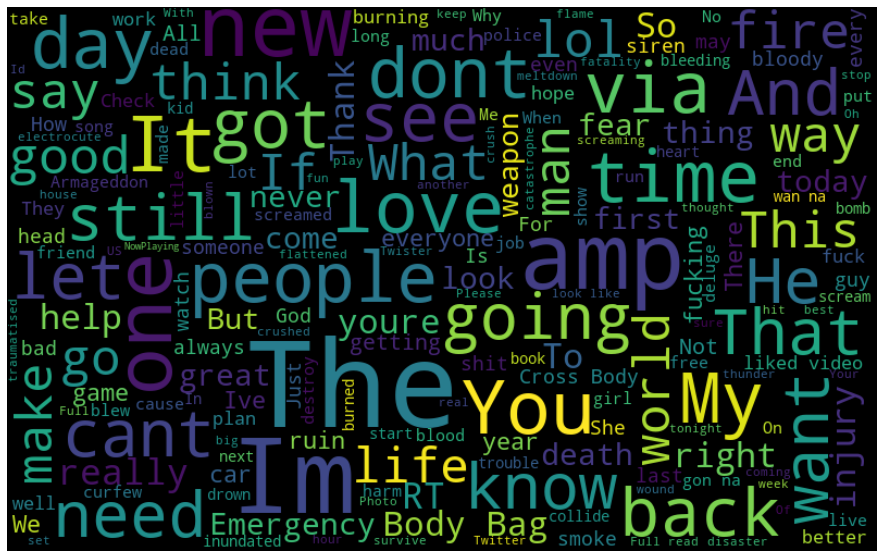

In [28]:
all_words = ' '.join([text for text in Merge_df['text'][Merge_df['target']==0]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(16, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

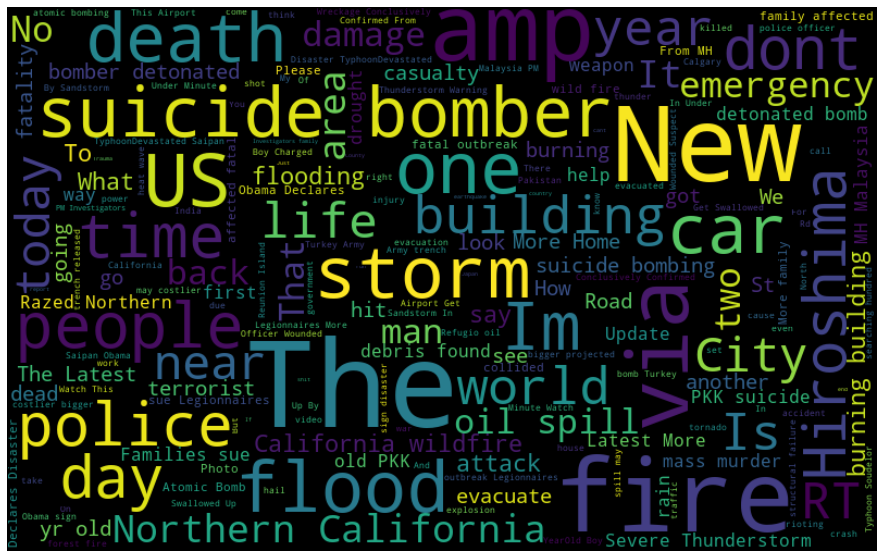

In [29]:
all_words = ' '.join([text for text in Merge_df['text'][Merge_df['target']==1]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(16, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=300, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(Merge_df['text'])

In [31]:
tfidf.shape

(10876, 300)

In [32]:
Final_train = tfidf[:7613]
Final_test = tfidf[7613:]

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

xtrain = Final_train[:5331]
xvalid = Final_train[5331:]
ytrain = Merge_df[:5331]['target']
yvalid = Merge_df[5331:7613]['target']

parameter = {'solver':['liblinear','lbfgs'],
            'max_iter':[200,400]}

Logis_clf = LogisticRegression()

lreg = GridSearchCV(Logis_clf, param_grid = parameter, cv = 3, verbose=True, n_jobs=-1)
lreg.fit(xtrain, ytrain) # training the model

prediction = lreg.predict_proba(xvalid) # predicting on the validation set

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.1s finished


ROC AUC=0.770


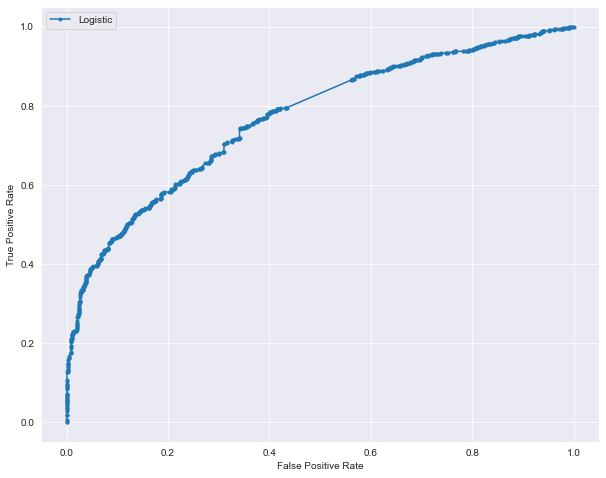

In [34]:
from sklearn.metrics import roc_auc_score,roc_curve,f1_score, confusion_matrix


# keep probabilities for the positive outcome only
lr_probs = prediction[:, 1]
lr_auc = roc_auc_score(yvalid, lr_probs)


print('ROC AUC=%.3f' % (lr_auc))

lr_fpr, lr_tpr, _ = roc_curve(yvalid, lr_probs)

# plot the roc curve for the model
plt.figure(figsize=(10,8))
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [35]:
prediction_int = prediction[:,1] >= 0.35
prediction_int = prediction_int.astype(np.int)
f1score = f1_score(yvalid,prediction_int)
print('F1 Score : %.3f' %(f1score))
conf = confusion_matrix(yvalid,prediction_int)
print(conf)

F1 Score : 0.682
[[788 485]
 [236 773]]


In [37]:
prediction = lreg.predict_proba(Final_test) # predicting on the test set

prediction_int = prediction[:,1] >= 0.35
prediction_int = prediction_int.astype(np.int)

In [38]:
NB_Clf = MultinomialNB()
NB_Clf.fit(xtrain, ytrain)

pred_naive = NB_Clf.predict(xvalid)
conf = confusion_matrix(yvalid, pred_naive)
print(conf)

f1score = f1_score(yvalid,pred_naive)
print('F1 Score : %.3f' %(f1score))

pred_naive_test = NB_Clf.predict(Final_test)
pred_naive_test = pred_naive_test.astype(int)

[[966 307]
 [390 619]]
F1 Score : 0.640


In [39]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}
SVM_Model = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=3, n_jobs=-1).fit(xtrain, ytrain)

In [40]:
pred_SVM_valid = SVM_Model.predict(xvalid)
pred_SVM_valid = pred_SVM_valid.astype(int)

conf = confusion_matrix(yvalid, pred_SVM_valid)
print(conf)

f1score = f1_score(yvalid,pred_SVM_valid)
print('F1 Score : %.3f' %(f1score))

[[1031  242]
 [ 431  578]]
F1 Score : 0.632


In [44]:
test_df['target'] = prediction_int

Final_submission= test_df[['id','target']]
Final_submission.to_csv('submission.csv',index=False)